In [2]:
!cp /content/drive/MyDrive/Colab\ Notebooks/neural_machine_translation/rnn.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/neural_machine_translation/data_utils.py /content

In [3]:
!mkdir data-bin
!mkdir model
!mkdir data

In [4]:
!cp /content/drive/MyDrive/Colab\ Notebooks/neural_machine_translation/data-bin/* /content/data-bin
!cp /content/drive/MyDrive/Colab\ Notebooks/neural_machine_translation/model/* /content/model
!cp /content/drive/MyDrive/Colab\ Notebooks/neural_machine_translation/data/* /content/data


In [13]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
import string
import random
from data_utils import *
from rnn import *
import torch
import codecs
from tqdm import tqdm
import string

#Set GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load vocabulary files
input_lang = torch.load('data-bin/fra.data')
output_lang = torch.load('data-bin/eng.data')

#Create and empty RNN model
encoder = EncoderRNN(input_size=input_lang.n_words, device=device)
attn_decoder = AttnDecoderRNN(output_size=output_lang.n_words, device=device)

#Load the saved model weights into the RNN model
encoder.load_state_dict(torch.load('model/encoder'))
attn_decoder.load_state_dict(torch.load('model/decoder'))

#Return the decoder output given input sentence 
#Additionally, the previous predicted word and previous decoder state can also be given as input
def translate_single_word(encoder, decoder, sentence, decoder_input=None, decoder_hidden=None, max_length=MAX_LENGTH, device=device):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]
        
        encoder = encoder.to(device)
        decoder = decoder.to(device)
        
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        if decoder_input==None:
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        else:
            decoder_input = torch.tensor([[output_lang.word2index[decoder_input]]], device=device) 
        
        if decoder_hidden == None:        
            decoder_hidden = encoder_hidden
        
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        return decoder_output.data, decoder_hidden

#########################################################################################
#####Modify this function to use beam search to predict instead of greedy prediction#####
#########################################################################################
def beam_search(encoder,decoder,input_sentence,beam_size = 1 ,max_length=MAX_LENGTH):
    decoded_output = []
    
    #Predicted the first word
    decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, decoder_input=None, decoder_hidden=None)
    
    #Get the probability of all output words
    decoder_output_probs = decoder_output.data
    
    #Select the id of the word with maximum probability
    idx = torch.argmax(decoder_output_probs)
	
    #Convert the predicted id to the word
    first_word = output_lang.index2word[idx.item()]
    
    #Add the predicted word to the output list and also set it as the previous prediction
    decoded_output.append(first_word)
    previous_decoded_output = first_word
    
    #Loop until the maximum length
    for i in range(max_length):
    
        #Predict the next word given the previous prediction and the previous decoder hidden state
        decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, previous_decoded_output, decoder_hidden)
        
        #Get the probability of all output words
        decoder_output_probs = decoder_output.data
        
        #Select the id of the word with maximum probability
        idx = torch.argmax(decoder_output_probs)
        
        #Break if end of sentence is predicted
        if idx.item() == EOS_token:
            break 
            
        #Else add the predicted word to the list
        else:
            #Convert the predicted id to the word
            selected_word = output_lang.index2word[idx.item()]
            
            #Add the predicted word to the output list and update the previous prediction
            decoded_output.append(selected_word)    
            previous_decoded_output = selected_word
            
    #Convert list of predicted words to a sentence and detokenize 
    output_translation = " ".join(i for i in decoded_output)
    
    return output_translation


# target_sentences = ["i can speak a bit of french .",
#         "i ve bought some cheese and milk .",
#         "boy where is your older brother ?",
#         "i ve just started reading this book .",
#         "she loves writing poems ."]

target_sentences = []

with open('data/test.eng') as targetS:
    for line in targetS:
        target_sentences.append(line)


# source_sentences = ["je parle un peu francais .",
#             "j ai achete du fromage et du lait .",
#             "garcon ou est ton grand frere ?",
#             "je viens justement de commencer ce livre .",
#             "elle adore ecrire des poemes ."]

source_sentences = []

with open('data/test.fra') as sourceS:
    for line in sourceS:
        source_sentences.append(line)



target = codecs.open('example.txt','w',encoding='utf-8')
test_out = codecs.open('test_beam_1.out','w',encoding='utf-8')

beam_size = 1 
for i,source_sentence in enumerate(source_sentences):

    target_sentence = normalizeString(target_sentences[i])
    input_sentence = normalizeString(source_sentence)
    
    hypothesis = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)
    
    # print("S-"+str(i)+": "+input_sentence)
    # print("T-"+str(i)+": "+target_sentence)
    # print("H-"+str(i)+": "+hypothesis)
    # print()
    target.write(hypothesis+'\n')

    # test_out.write("S-"+str(i)+": "+input_sentence+'\n')
    # test_out.write("T-"+str(i)+": "+target_sentence+'\n')
    test_out.write(hypothesis+'\n')

target.close()
test_out.close()    


In [14]:
pip install sacrebleu 

In [15]:
!sacrebleu data/test.eng < test_beam_1.out

sacreBLEU: That's 100 lines that end in a tokenized period ('.')
sacreBLEU: It looks like you forgot to detokenize your test data, which may hurt your score.
sacreBLEU: If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
{
 "name": "BLEU",
 "score": 13.0,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.0.0",
 "verbose_score": "41.5/13.8/8.3/6.0 (BP = 1.000 ratio = 1.037 hyp_len = 6446 ref_len = 6218)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.0.0"
}


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


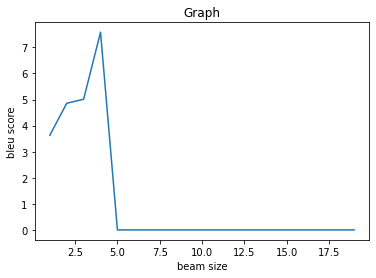

In [23]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
import string
import random
from data_utils import *
from rnn import *
import torch
import codecs
from tqdm import tqdm
import string
import sacrebleu
import matplotlib.pyplot as plt

#Set GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load vocabulary files
input_lang = torch.load('data-bin/fra.data')
output_lang = torch.load('data-bin/eng.data')

#Create and empty RNN model
encoder = EncoderRNN(input_size=input_lang.n_words, device=device)
attn_decoder = AttnDecoderRNN(output_size=output_lang.n_words, device=device)

#Load the saved model weights into the RNN model
encoder.load_state_dict(torch.load('model/encoder'))
attn_decoder.load_state_dict(torch.load('model/decoder'))

#Return the decoder output given input sentence 
#Additionally, the previous predicted word and previous decoder state can also be given as input
def translate_single_word(encoder, decoder, sentence, decoder_input=None, decoder_hidden=None, max_length=MAX_LENGTH, device=device):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]
        
        encoder = encoder.to(device)
        decoder = decoder.to(device)
        
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        if decoder_input==None:
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        else:
            decoder_input = torch.tensor([[output_lang.word2index[decoder_input]]], device=device) 
        
        if decoder_hidden == None:        
            decoder_hidden = encoder_hidden
        
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        return decoder_output.data, decoder_hidden

#########################################################################################
#####Modify this function to use beam search to predict instead of greedy prediction#####
#########################################################################################
def beam_search(encoder,decoder,input_sentence,beam_size = 1 ,max_length=MAX_LENGTH):
    decoded_output = []
    
    #Predicted the first word
    decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, decoder_input=None, decoder_hidden=None)
    
    #Get the probability of all output words
    decoder_output_probs = decoder_output.data
    
    #Select the id of the word with maximum probability
    idx = torch.argmax(decoder_output_probs)
    previousWinProbability = decoder_output_probs[0][idx] # will be used for the beam search

    #Convert the predicted id to the word
    first_word = output_lang.index2word[idx.item()]
    
    #Add the predicted word to the output list and also set it as the previous prediction
    decoded_output.append(first_word)
    previous_decoded_output = first_word
    
    #Loop until the maximum length
    for i in range(max_length):
    
        #Predict the next word given the previous prediction and the previous decoder hidden state
        decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, previous_decoded_output, decoder_hidden)
        
        #Get the probability of all output words
        decoder_output_probs = decoder_output.data
        

        #Select the id of the word with maximum probability
        #xxx idx = torch.argmax(decoder_output_probs)

        # *************** sort all new sequences in the descending order of their score ***************
        sorted_decoder_output_probs = torch.sort(decoder_output_probs, descending=True)
        idxList = []
        probabilityList = []
        #xxx get top n (beam-size) scores
        for x in range(beam_size):
            idxList.append(sorted_decoder_output_probs[1][0][x])
            idx = sorted_decoder_output_probs[1][0][x]
            probabilityList.append((sorted_decoder_output_probs[0][0][x]) * previousWinProbability)
            selected_word = output_lang.index2word[idx.item()]
            previous_decoded_output = selected_word
            if previous_decoded_output != 'EOS':
                decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, previous_decoded_output, decoder_hidden)
        
        previousWinProbability = max(probabilityList)
        idx_max = max(range(len(probabilityList)), key=probabilityList.__getitem__)
        idx = idxList[idx_max]
        
        #Break if end of sentence is predicted
        if idx.item() == EOS_token:
            break 
            
        #Else add the predicted word to the list
        else:
            #Convert the predicted id to the word
            selected_word = output_lang.index2word[idx.item()]
            
            #Add the predicted word to the output list and update the previous prediction
            decoded_output.append(selected_word)    
            previous_decoded_output = selected_word
            
    #Convert list of predicted words to a sentence and detokenize 
    output_translation = " ".join(i for i in decoded_output)
    
    return output_translation


target_sentences = []

with open('data/valid.eng') as targetS:
    for line in targetS:
        target_sentences.append(line)

source_sentences = []

with open('data/valid.fra') as sourceS:
    for line in sourceS:
        source_sentences.append(line)

bleu_scores = []
beam_values = []
beamSizeMax = 19
for x in range(beamSizeMax):
    beam_size = x+1
    beam_values.append(beam_size)
    predictions = []
    print(str(beam_size))
    for i,source_sentence in enumerate(source_sentences):
        target_sentence = normalizeString(target_sentences[i])
        input_sentence = normalizeString(source_sentence)
        hypothesis = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)
    
        predictions.append(hypothesis)
  
    
    bleu = sacrebleu.corpus_bleu(predictions, target_sentences)
    bleu_scores.append(bleu.score)

plt.plot(beam_values, bleu_scores)

# naming the x axis
plt.xlabel('beam size')
# naming the y axis
plt.ylabel('bleu score')
 
# giving a title to my graph
plt.title('Graph')
 
# function to show the plot
plt.show()


In [28]:
target_sentences = []

with open('data/test.eng') as targetS:
    for line in targetS:
        target_sentences.append(line)


source_sentences = []

with open('data/test.fra') as sourceS:
    for line in sourceS:
        source_sentences.append(line)



test_out = codecs.open('test_beam_1.out','w',encoding='utf-8')

beam_size = 4 # optimal beam size calculated in prior step 
for i,source_sentence in enumerate(source_sentences):

    target_sentence = normalizeString(target_sentences[i])
    input_sentence = normalizeString(source_sentence)
    
    hypothesis = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)

    test_out.write(hypothesis+'\n')

target.close()
test_out.close()    


In [29]:
!sacrebleu data/test.eng < test_beam_1.out

sacreBLEU: That's 100 lines that end in a tokenized period ('.')
sacreBLEU: It looks like you forgot to detokenize your test data, which may hurt your score.
sacreBLEU: If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
{
 "name": "BLEU",
 "score": 1.6,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.0.0",
 "verbose_score": "55.6/8.5/0.6/1.2 (BP = 0.378 ratio = 0.507 hyp_len = 3151 ref_len = 6218)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.0.0"
}
